=== Trial 1 ===
SFOA Benchmark 1: Sphere Function
SFOA Benchmark 2: WSN Coverage Optimization
PSO Benchmark 1: Sphere Function
PSO Benchmark 2: WSN Coverage Optimization
DE Benchmark 1: Sphere Function
DE Benchmark 2: WSN Coverage Optimization

=== Trial 2 ===
SFOA Benchmark 1: Sphere Function
SFOA Benchmark 2: WSN Coverage Optimization
PSO Benchmark 1: Sphere Function
PSO Benchmark 2: WSN Coverage Optimization
DE Benchmark 1: Sphere Function
DE Benchmark 2: WSN Coverage Optimization

=== Trial 3 ===
SFOA Benchmark 1: Sphere Function
SFOA Benchmark 2: WSN Coverage Optimization
PSO Benchmark 1: Sphere Function
PSO Benchmark 2: WSN Coverage Optimization
DE Benchmark 1: Sphere Function
DE Benchmark 2: WSN Coverage Optimization

=== Trial 4 ===
SFOA Benchmark 1: Sphere Function
SFOA Benchmark 2: WSN Coverage Optimization
PSO Benchmark 1: Sphere Function
PSO Benchmark 2: WSN Coverage Optimization
DE Benchmark 1: Sphere Function
DE Benchmark 2: WSN Coverage Optimization

=== Trial 5 ===
SFOA

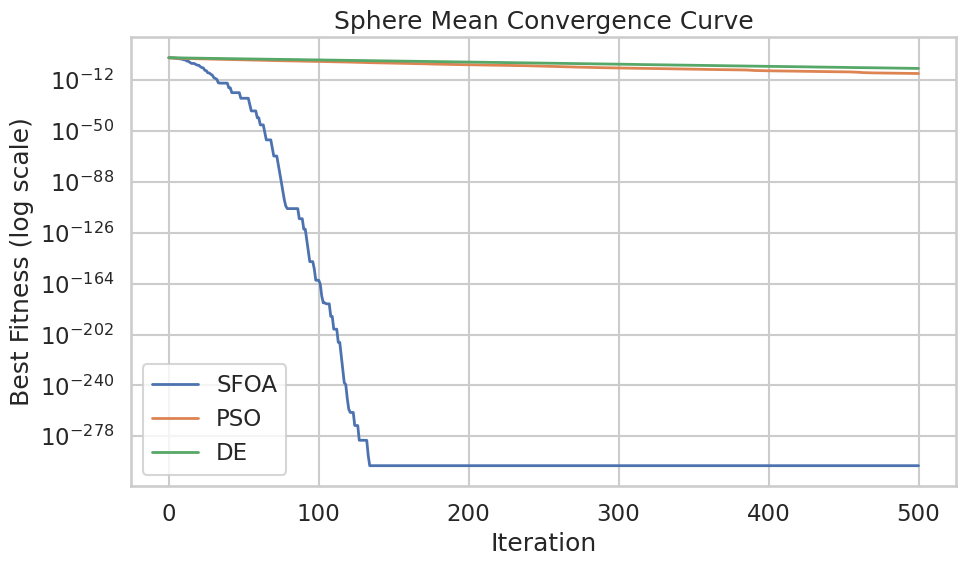

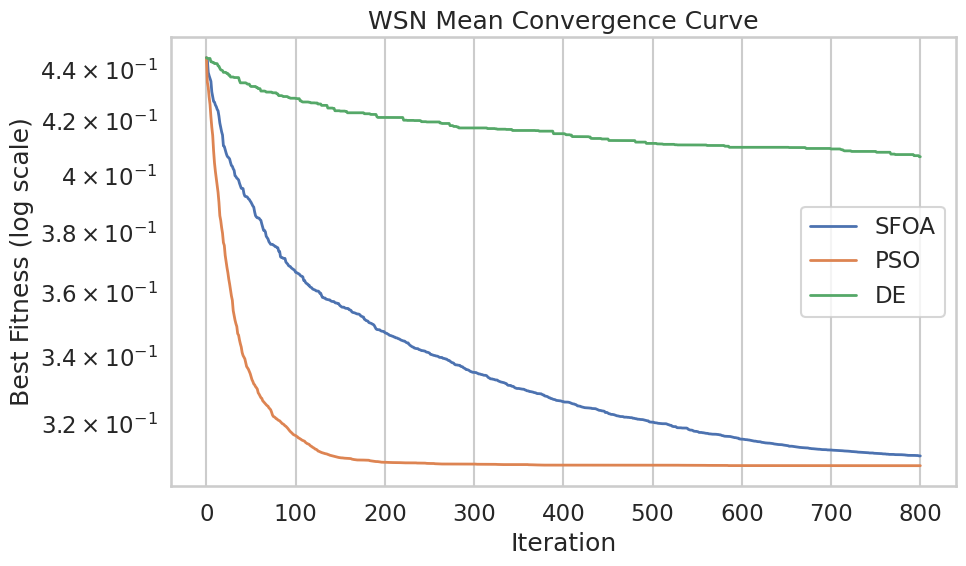

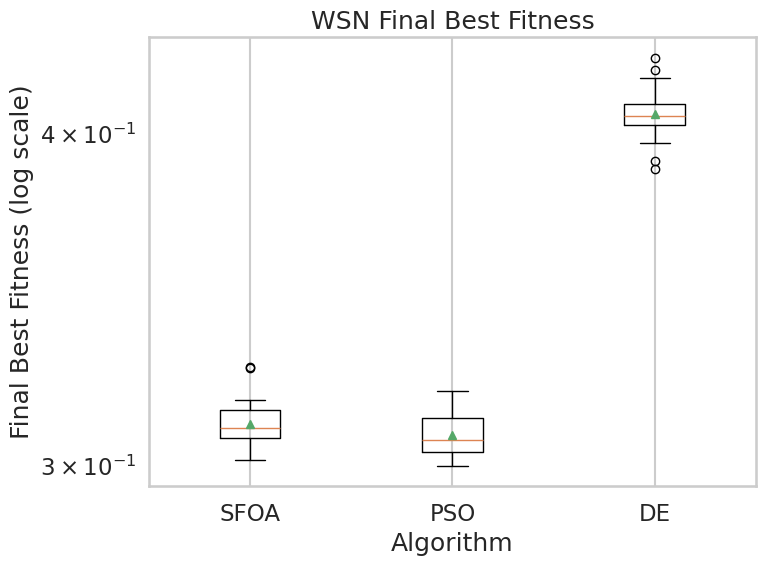

Sphere: Pairwise Wilcoxon tests (p-values, Holm-corrected)
SFOA vs PSO	1.8626e-09	1.6667e-02	YES
SFOA vs DE	1.8626e-09	2.5000e-02	YES
PSO vs DE	1.8626e-09	5.0000e-02	YES
WSN: Pairwise Wilcoxon tests (p-values, Holm-corrected)
SFOA vs DE	1.7333e-06	1.6667e-02	YES
PSO vs DE	1.7333e-06	2.5000e-02	YES
SFOA vs PSO	1.1796e-01	5.0000e-02	no


In [1]:
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
from SFOA import (
    sfoa,
    sphere,
    sphere_bounds,
    wsn_bounds,
    wsn_coverage_fitness
)
from PSO import pso
from DE import de
from scipy.stats import wilcoxon
import os

os.environ["CUDA_VISIBLE_DEVICES"]="3"
sns.set_theme(style="whitegrid", context="talk")

def plot_convergence_multi(results, title="Mean Convergence Curve", logy=True):
    plt.figure(figsize=(10, 6))

    for name, data in results.items():
        curves = np.array(data["curves"])      # shape: (runs, iters)
        mean_curve = curves.mean(axis=0)

        if logy:
            eps = 1e-300
            mean_curve = np.maximum(mean_curve, eps)

        plt.plot(mean_curve, label=name, linewidth=2)

    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness (log scale)" if logy else "Best Fitness")
    if logy:
        plt.yscale("log")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_boxplot_final(results, title="Final Best Fitness", logy=True):
    labels = []
    data = []

    for name, d in results.items():
        labels.append(name)
        data.append(d["scores"])

    plt.figure(figsize=(8, 6))
    plt.boxplot(data, tick_labels=labels, showmeans=True)

    plt.xlabel("Algorithm")
    plt.ylabel("Final Best Fitness")
    if logy:
        plt.yscale("log")
        plt.ylabel("Final Best Fitness (log scale)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def statistical_test(results, problem):
    algo_names = list(results.keys())
    scores = [results[name]["scores"] for name in algo_names]

    #check shapes
    n_runs = len(scores[0])
    assert all(len(s) == n_runs for s in scores), "All algorithms must have same #runs"

    print(f"{problem}: Pairwise Wilcoxon tests (p-values, Holm-corrected)")

    pair_pvals = {}
    for i in range(len(algo_names)):
        for j in range(i + 1, len(algo_names)):
            a, b = algo_names[i], algo_names[j]
            stat_ij, p_ij = wilcoxon(results[a]["scores"], results[b]["scores"])
            pair_pvals[(a, b)] = p_ij

    items = sorted(pair_pvals.items(), key=lambda kv: kv[1])
    m = len(items)
    for k, ((a, b), p_raw) in enumerate(items, start=1):
        alpha = 0.05
        threshold = alpha / (m - k + 1)
        signif = p_raw < threshold
        print(f"{a} vs {b}\t{p_raw:.4e}\t{threshold:.4e}\t{'YES' if signif else 'no'}")

def sfoa_run_sphere_benchmark(i, list, list2):
    print("SFOA Benchmark 1: Sphere Function")

    dim = 30
    bounds = sphere_bounds(dim)

    best_pos, best_score, curve = sfoa(
        obj_func=sphere,
        bounds=bounds,
        n_starfish=50,
        iter=500,
        gp=0.5,
        random_state=i
    )

    list.append(best_score)
    list2.append(curve)

def pso_run_sphere_benchmark(i, list, list2):
    print("PSO Benchmark 1: Sphere Function")

    dim = 30
    bounds = sphere_bounds(dim)

    best_pos, best_score, curve = pso(
        obj_func=sphere,
        bounds=bounds,
        num_particles=50,
        iter=500,
        random_state=i,
    )

    list.append(best_score)
    list2.append(curve)

def de_run_sphere_benchmark(i, list, list2):
    print("DE Benchmark 1: Sphere Function")

    dim = 30
    bounds = sphere_bounds(dim)

    best_pos, best_score, curve = de(
        obj_func=sphere,
        bounds=bounds,
        pop_size=50,
        max_iter=500,
        F=0.5,
        CR=0.9,
        random_state=i,
    )

    list.append(best_score)
    list2.append(curve)

def sfoa_run_wsn_benchmark(i, list, list2):
    print("SFOA Benchmark 2: WSN Coverage Optimization")

    num_sensors = 10
    area_size = 100.0
    radius = 15.0

    bounds = wsn_bounds(num_sensors, area_size)

    def wsn_obj(x):
        return wsn_coverage_fitness(
            x,
            num_sensors=num_sensors,
            radius = radius,
            area_size=area_size,
            grid_res=50
        )

    best_pos, best_score, curve = sfoa(
        obj_func=wsn_obj,
        bounds=bounds,
        n_starfish=60,
        iter=800,
        gp=0.5,
        random_state=i,
    )

    list.append(best_score)
    list2.append(curve)

def pso_run_wsn_benchmark(i, list, list2):
    print("PSO Benchmark 2: WSN Coverage Optimization")

    num_sensors = 10
    area_size = 100.0
    radius = 15.0

    bounds = wsn_bounds(num_sensors, area_size)

    def wsn_obj(x):
        return wsn_coverage_fitness(
            x,
            num_sensors=num_sensors,
            radius = radius,
            area_size=area_size,
            grid_res=50
        )

    best_pos, best_score, curve = pso(
        obj_func=wsn_obj,
        bounds=bounds,
        num_particles=60,
        iter=800,
        random_state=i,
    )

    list.append(best_score)
    list2.append(curve)

def de_run_wsn_benchmark(i, list, list2):
    print("DE Benchmark 2: WSN Coverage Optimization")

    num_sensors = 10
    area_size = 100.0
    radius = 15.0

    bounds = wsn_bounds(num_sensors, area_size)

    def wsn_obj(x):
        return wsn_coverage_fitness(
            x,
            num_sensors=num_sensors,
            radius = radius,
            area_size=area_size,
            grid_res=50
        )

    best_pos, best_score, curve = de(
        obj_func=wsn_obj,
        bounds=bounds,
        pop_size=60,
        max_iter=800,
        F=0.7,
        CR=0.9,
        random_state=i
    )

    list.append(best_score)
    list2.append(curve)

def run_trials(num_runs=30):
    sfoa_sphere_curves, pso_sphere_curves, de_sphere_curves = [], [], []
    sfoa_wsn_curves, pso_wsn_curves, de_wsn_curves = [], [], []
    sfoa_sphere_scores, pso_sphere_scores, de_sphere_scores = [], [], []
    sfoa_wsn_scores, pso_wsn_scores, de_wsn_scores = [], [], []
    for num_runs in range(num_runs):
        print(f"=== Trial {num_runs + 1} ===")
        sfoa_run_sphere_benchmark(num_runs, sfoa_sphere_scores, sfoa_sphere_curves)
        sfoa_run_wsn_benchmark(num_runs, sfoa_wsn_scores, sfoa_wsn_curves)
        pso_run_sphere_benchmark(num_runs, pso_sphere_scores, pso_sphere_curves)
        pso_run_wsn_benchmark(num_runs, pso_wsn_scores, pso_wsn_curves)
        de_run_sphere_benchmark(num_runs, de_sphere_scores, de_sphere_curves)
        de_run_wsn_benchmark(num_runs, de_wsn_scores, de_wsn_curves)
        print()

    sfoa_sphere_median = st.median(sfoa_sphere_scores)
    sfoa_sphere_mean = st.mean(sfoa_sphere_scores)
    sfoa_sphere_std = st.stdev(sfoa_sphere_scores)
    pso_sphere_median = st.median(pso_sphere_scores)
    pso_sphere_mean = st.mean(pso_sphere_scores)
    pso_sphere_std = st.stdev(pso_sphere_scores)
    de_sphere_median = st.median(de_sphere_scores)
    de_sphere_mean = st.mean(de_sphere_scores)
    de_sphere_std = st.stdev(de_sphere_scores)

    sfoa_wsn_median = st.median(sfoa_wsn_scores)
    sfoa_wsn_mean = st.mean(sfoa_wsn_scores)
    sfoa_wsn_std = st.stdev(sfoa_wsn_scores)
    pso_wsn_median = st.median(pso_wsn_scores)
    pso_wsn_mean = st.mean(pso_wsn_scores)
    pso_wsn_std = st.stdev(pso_wsn_scores)
    de_wsn_median = st.median(de_wsn_scores)
    de_wsn_mean = st.mean(de_wsn_scores)
    de_wsn_std = st.stdev(de_wsn_scores)

    print(f"SFOA Sphere Median: {sfoa_sphere_median:.6e}")
    print(f"SFOA Sphere Mean: {sfoa_sphere_mean:.6e}")
    print(f"SFOA Sphere Standard Dev: {sfoa_sphere_std:.6e}")
    print()
    print(f"SFOA WSN Median: {sfoa_wsn_median:.6e}")
    print(f"SFOA WSN Mean: {sfoa_wsn_mean:.6e}")
    print(f"SFOA WSN Standard Dev: {sfoa_wsn_std:.6e}")
    print()
    print(f"PSO Sphere Median: {pso_sphere_median:.6e}")
    print(f"PSO Sphere Mean: {pso_sphere_mean:.6e}")
    print(f"PSO Sphere Standard Dev: {pso_sphere_std:.6e}")
    print()
    print(f"PSO WSN Median: {pso_wsn_median:.6e}")
    print(f"PSO WSN Mean: {pso_wsn_mean:.6e}")
    print(f"PSO WSN Standard Dev: {pso_wsn_std:.6e}")
    print()
    print(f"DE Sphere Median: {de_sphere_median:.6e}")
    print(f"DE Sphere Mean: {de_sphere_mean:.6e}")
    print(f"DE Sphere Standard Dev: {de_sphere_std:.6e}")
    print()
    print(f"DE WSN Median: {de_wsn_median:.6e}")
    print(f"DE WSN Mean: {de_wsn_mean:.6e}")
    print(f"DE WSN Standard Dev: {de_wsn_std:.6e}")
    print()

    sphere_results = {
        "SFOA": {"curves": sfoa_sphere_curves, "scores": np.array(sfoa_sphere_scores)},
        "PSO":  {"curves": pso_sphere_curves,  "scores": np.array(pso_sphere_scores)},
        "DE":   {"curves": de_sphere_curves,   "scores": np.array(de_sphere_scores)},
    }

    wsn_results = {
        "SFOA": {"curves": sfoa_wsn_curves, "scores": np.array(sfoa_wsn_scores)},
        "PSO":  {"curves": pso_wsn_curves,  "scores": np.array(pso_wsn_scores)},
        "DE":   {"curves": de_wsn_curves,   "scores": np.array(de_wsn_scores)},
    }

    wsn_all_scores = np.concatenate([
        wsn_results["SFOA"]["scores"],
        wsn_results["PSO"]["scores"],
        wsn_results["DE"]["scores"],
    ])

    best_overall = np.min(wsn_all_scores)

    summary = {}

    for algo in wsn_results.keys():
        scores = wsn_results[algo]["scores"]
        successes = np.sum(scores <= best_overall + 0.02)
        total_runs = len(scores)
        rate = successes / total_runs

        summary[algo] = {
            "successes": successes,
            "total_runs": total_runs,
            "success_rate": rate,
        }

        print(f"{algo}: {successes}/{total_runs} "
              f"({rate*100:.1f}% success)")

    plot_convergence_multi(sphere_results, title="Sphere Mean Convergence Curve", logy=True)
    plot_convergence_multi(wsn_results, title="WSN Mean Convergence Curve", logy=True)

    plot_boxplot_final(wsn_results, title="WSN Final Best Fitness", logy=True)

    statistical_test(sphere_results, "Sphere")
    statistical_test(wsn_results, "WSN")

def main():
    run_trials()
    

if __name__ == "__main__":
    main()